### Sentiment analysis of tweets regarding female sports

In this study, we first try by extracting tweets with the help of hashtags used to refer to female performances in general. This is done within a certain period.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tweepy
import re
import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
#Twitter credentials for the app
consumer_key = 'XXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_key= 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'


In [3]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [86]:
#declare file paths as follows for three files
femaleS_tweets = "data2/Sports/femalesports2.csv"

In [87]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
'favorite_count', 'retweet_count', 'original_author',   'possibly_sensitive', 'hashtags',
'user_mentions', 'place', 'place_coord_boundaries']

In [88]:
#set two date variables for date range
start_date = '2018-10-01'
end_date = '2019-12-27'

In [89]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])


# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])


#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)


#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [90]:
#method to clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [95]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    #api = tweepy.API(auth)
    #places = api.geo_search(query="FRANCE", granularity="country") Here I wanted to precise tweets from France only, but did not work with pagination
    #place_id = places[0].id
    for page in tweepy.Cursor(api.search, q=keyword, #(q="place:%s" % place_id), q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = status['text'] # p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [96]:
#declare keywords as a query for three categories
femaleS_keywords = '#femalesports OR #girlsports OR #femalefootball OR #femalebasket OR #femaleboxing OR #femaletournament OR #femalevoleyball OR #womeninsport OR #womensfootball'# OR #thisgirlcan'

In [97]:
#call main method passing keywords and file path
write_tweets(femaleS_keywords,  femaleS_tweets)

### ANALYSIS OF THE EXTRACTED DATA

In [6]:
femaleS_tweets1 = "data2/Sports/femalesports2.csv"

In [9]:
df1 = pd.read_csv(femaleS_tweets1) 

In [10]:
for col in df1.columns: 
    print(col)
  

id
created_at
source
original_text
clean_text
sentiment
polarity
subjectivity
lang
favorite_count
retweet_count
original_author
possibly_sensitive
hashtags
user_mentions
place
place_coord_boundaries


In [60]:
#places = df1.place #== "France"
#polarity = df1.polarity
df1.user_mentions

0                                              SheKicksFA
1                              femininecollect, GKSWriter
2                                               AthensWFS
3                                                sprusina
4                                           DanielleWarby
                              ...                        
3775                                                  NaN
3776                                             20x20_ie
3777    jobsonhphoto, DurhamWFC, LCWFC_official, Durha...
3778                                                  NaN
3779     DurhamWFC, LCWFC_official, DurhamCestria, NERWFL
Name: user_mentions, Length: 3780, dtype: object

In [2]:
vector_places = []
for col in places: 
    print(col)
    vector_places.append(col)
  #The tweets are coming from the following places:
data_places=pd.DataFrame(vector_places, columns=['Places'])

In [13]:
data_places

,Places
0,"Goa, India"
1,Arizona
2,"Beverly Hills, CA"
3,Calgary
4,Portsmouth
...,...
3775,NaN
3776,"Wexford, Ireland"
3777,"North East, England"
3778,NaN


In [14]:
file1 = "data2/Sports/tweet_places2.csv"
csvFile = open(file1, 'a' ,encoding='utf-8')
data_places.to_csv(csvFile, mode='a', columns=['Places'], index=False, encoding="utf-8")

In [15]:
#for sent in polarity:
#    print(sent)

In [1]:
vector_of_sentiments = []
a = 0
polarity = df1.polarity
for sent in polarity:
    if float(sent) > 0:
        print('Positive')
        a = 1
        vector_of_sentiments.append(a)
    else:
        print('Negative')
        a = 0
        vector_of_sentiments.append(a)
    #print("")

In [17]:
#print('The sentiment vector is:', vector_of_sentiments)
print('The number of positives is:', vector_of_sentiments.count(1))
print('The number of negatives is:', vector_of_sentiments.count(0))

The number of positives is: 2554
The number of negatives is: 1226


[1226 2554]


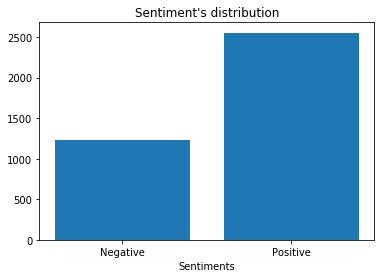

In [18]:
labels, counts = np.unique(vector_of_sentiments, return_counts=True)
print(counts)
labels1 = ["Negative","Positive"]
plt.bar(labels1, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Sentiments")
plt.title("Sentiment's distribution")
plt.show()

We observed that we have more positive comments than negative ones :)

In [ ]:
file1 = "data2/Sports/tweet_places2.csv"
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataTPs.csv",encoding = "ISO-8859-1")
data.head()

In [21]:
places_count

Sunshine Coast, Queensland        51
Australia                         46
United Kingdom                    36
London, England                   32
Melbourne, Australia              30
                                  ..
Northern Ireland                   1
Toronto but really Mississauga     1
Ireland Canada                     1
Éire                               1
Stevens Point, Wisconsin, USA      1
Name: place, Length: 1444, dtype: int64

In [54]:
places_count.values[86]

5

In [57]:
#fig, ax = plt.subplots(figsize=(10,100)) #plt.figsize=(14,6)
#fig.set_size_inches(12, 6)
#df1['place'].value_counts()[:100].plot(kind='barh')


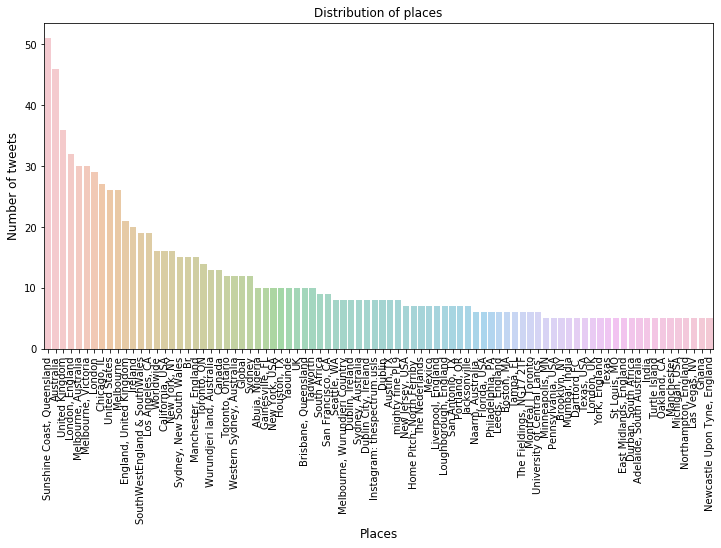

In [56]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#g= sns.barplot(x='name', y='vals', data=donne)
places_count = df1['place'].value_counts()[:86]
#sns.set(style="darkgrid")
#donne['Residence'] = donne['Residence'].astype(str)
fig, ax = plt.subplots(figsize=(15,6)) #plt.figsize=(14,6)
fig.set_size_inches(12, 6)
#sns.violinplot(ax=ax, data=donne['Residence'], inner="points" ) #**violin_options)
#for (places_count.values > 1):
g = sns.barplot(places_count.index, places_count.values, alpha=0.5)
g.set_xticklabels(labels =places_count.index, rotation=90)
plt.title('Distribution of places')
plt.ylabel('Number of tweets', fontsize=12)
plt.xlabel('Places', fontsize=12)
plt.show()